In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from scipy.spatial import cKDTree





In [2]:
class AnnoyIndex():
    def __init__(self, vectors, labels, metric):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels    
        self.metric= metric
   
    def build(self, number_of_trees=100):
        self.index = annoy.AnnoyIndex(self.dimension, self.metric)
        for i, vec in enumerate(self.vectors):
            self.index.add_item(i, vec.tolist())
        self.index.build(number_of_trees)
        
    def query(self, vector, k=1000):
        indices = self.index.get_nns_by_vector(
              vector.tolist(), 
              k, 
              search_k=-1)                                           
        return [self.labels[i] for i in indices]

In [3]:
# Visually vetted GHOST results split up over 6 files
# So merge them, and take subset of just YSE DR1 objects

dfs = []
for idx in range(1, 7):
    df = pd.read_csv(f'../yse_ghost_hosts_before_vetting/{idx}_of_5/ghost_hosts.csv')
    dfs.append(df)
    
g_hosts_df = pd.concat(dfs, axis=0).reset_index(drop=True)
g_hosts_df = g_hosts_df.set_index('TransientName')
g_hosts_df.sort_values('TransientName', inplace=True)
ps1_hosts_df = g_hosts_df.reset_index(drop=False)
ps1_hosts_df = ps1_hosts_df.set_index('TransientName')
ps1_hosts_df

,Unnamed: 0,level_0,index,objName,objAltName1,objAltName2,objAltName3,objID,uniquePspsOBid,ippObjID,...,NED_type,NED_vel,NED_redshift,NED_mag,class,dist/DLR,dist,TransientClass,TransientRA,TransientDEC
TransientName,,,,,,,,,,,,,,,,,,,,,
2017fgc,438,1083.0,1.0,PSO J012014.639+032412.408,NaN,NaN,NaN,112080200610004597,920640000012027,44345537343227,...,NaN,NaN,NaN,NaN,NaN,2.043633,3.864276,NaN,20.060167,3.402767
2019aaag,242,1587.0,13.0,PSO J122902.877+124305.856,NaN,NaN,NaN,123261872619862441,1075711000039539,102744207694452,...,G,NaN,NaN,19.8,False,0.042838,0.201594,NaN,187.262053,12.718327
2019aaax,96,632.0,20.0,PSO J101958.736-030625.511,NaN,NaN,NaN,104271549947461885,1044689000082043,378506877943937,...,G,NaN,NaN,21.8,False,0.015769,0.060278,NaN,154.994731,-3.107074
2019aabv,338,2275.0,39.0,PSO J095020.993+320144.032,NaN,NaN,NaN,146431475874425238,1055533000070586,214804199445433,...,*,NaN,NaN,20.1,False,0.058378,0.192407,NaN,147.587449,32.028943
2019aacg,66,431.0,43.0,PSO J104738.560-043456.602,NaN,NaN,NaN,102501619106751538,1050657000004462,379005094072685,...,IrS,NaN,NaN,NaN,False,0.111747,0.244734,NaN,161.910702,-4.582341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022cpk,462,2825.0,8244.0,PSO J091328.597+310703.441,NaN,NaN,NaN,145341383690751801,1048059000053667,214151364399522,...,NaN,NaN,NaN,NaN,NaN,1.665415,4.059217,NaN,138.370342,31.117122
2022gy,210,1680.0,8252.0,PSO J122727.536+081137.071,NaN,NaN,NaN,117831868647142827,1038671000072790,102894531583061,...,G,35795.0,0.119398,17.6,False,0.218665,2.091249,NaN,186.864439,8.194126
2022jq,130,1096.0,8270.0,PSO J091327.581+010010.966,NaN,NaN,NaN,109201383649304082,1011152000032043,58437325061418,...,G,NaN,NaN,18.8,False,0.343289,1.654076,NaN,138.365050,1.003510


In [4]:
# explanation of PS1 features (not custom GHOST ones): 
# https://outerspace.stsci.edu/display/PANSTARRS/PS1+Database+object+and+detection+tables 

feature_names_hostgal = [
#  'Unnamed: 0',
#  'level_0',
#  'index',
#  'objName',
#  'objAltName1',
#  'objAltName2',
#  'objAltName3',
#  'objID',
#  'uniquePspsOBid',
#  'ippObjID',
#  'surveyID',
#  'htmID',
#  'zoneID',
#  'tessID',
#  'projectionID',
#  'skyCellID',
#  'randomID',
#  'batchID',
#  'dvoRegionID',
#  'processingVersion',
#  'objInfoFlag',
#  'qualityFlag',
#  'raStack',
#  'decStack',
#  'raStackErr',
#  'decStackErr',
#  'raMean',
#  'decMean',
#  'raMeanErr',
#  'decMeanErr',
#  'epochMean',
#  'posMeanChisq',
#  'cx',
#  'cy',
#  'cz',
#  'lambda',
#  'beta',
#  'l',
#  'b',
#  'nStackObjectRows',
#  'nStackDetections',
#  'nDetections',
#  'ng',
#  'nr',
#  'ni',
#  'nz',
#  'ny',
#  'uniquePspsSTid',
#  'primaryDetection',
#  'bestDetection',
#  'gippDetectID',
#  'gstackDetectID',
#  'gstackImageID',
#  'gra',
#  'gdec',
#  'graErr',
#  'gdecErr',
#  'gEpoch',
#  'gPSFMag',
#  'gPSFMagErr',
#  'gApMag',
#  'gApMagErr',
#  'gKronMag',
#  'gKronMagErr',
#  'ginfoFlag',
#  'ginfoFlag2',
#  'ginfoFlag3',
#  'gnFrames',
#  'gxPos',
#  'gyPos',
#  'gxPosErr',
#  'gyPosErr',
#  'gpsfMajorFWHM',
#  'gpsfMinorFWHM',
#  'gpsfTheta',
#  'gpsfCore',
#  'gpsfLikelihood',
#  'gpsfQf',
#  'gpsfQfPerfect',
#  'gpsfChiSq',
 'gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
#  'gPSFFluxErr',
 'gApFlux',
#  'gApFluxErr',
#  'gApFillFac',
#  'gApRadius',
 'gKronFlux',
#  'gKronFluxErr',
 'gKronRad',
#  'gexpTime',
 'gExtNSigma',
#  'gsky',
#  'gskyErr',
#  'gzp',
#  'gPlateScale',
#  'rippDetectID',
#  'rstackDetectID',
#  'rstackImageID',
#  'rra',
#  'rdec',
#  'rraErr',
#  'rdecErr',
#  'rEpoch',
# 'rPSFMag',
#  'rPSFMagErr',
# 'rApMag',
#  'rApMagErr',
# 'rKronMag',
#  'rKronMagErr',
#  'rinfoFlag',
#  'rinfoFlag2',
#  'rinfoFlag3',
#  'rnFrames',
#  'rxPos',
#  'ryPos',
#  'rxPosErr',
#  'ryPosErr',
#  'rpsfMajorFWHM',
#  'rpsfMinorFWHM',
#  'rpsfTheta',
#  'rpsfCore',
#  'rpsfLikelihood',
#  'rpsfQf',
#  'rpsfQfPerfect',
#  'rpsfChiSq',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
'rPSFFlux',
#  'rPSFFluxErr',
'rApFlux',
#  'rApFluxErr',
#  'rApFillFac',
# 'rApRadius',
'rKronFlux',
#  'rKronFluxErr',
'rKronRad',
#  'rexpTime',
 'rExtNSigma',
#  'rsky',
#  'rskyErr',
#  'rzp',
#  'rPlateScale',
#  'iippDetectID',
#  'istackDetectID',
#  'istackImageID',
#  'ira',
#  'idec',
#  'iraErr',
#  'idecErr',
#  'iEpoch',
#  'iPSFMag',
#  'iPSFMagErr',
#  'iApMag',
#  'iApMagErr',
#  'iKronMag',
#  'iKronMagErr',
#  'iinfoFlag',
#  'iinfoFlag2',
#  'iinfoFlag3',
#  'inFrames',
#  'ixPos',
#  'iyPos',
#  'ixPosErr',
#  'iyPosErr',
#  'ipsfMajorFWHM',
#  'ipsfMinorFWHM',
#  'ipsfTheta',
#  'ipsfCore',
#  'ipsfLikelihood',
#  'ipsfQf',
#  'ipsfQfPerfect',
#  'ipsfChiSq',
  'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
#  'iPSFFluxErr',
 'iApFlux',
#  'iApFluxErr',
#  'iApFillFac',
#  'iApRadius',
 'iKronFlux',
#  'iKronFluxErr',
 'iKronRad',
#  'iexpTime',
  'iExtNSigma',
#  'isky',
#  'iskyErr',
#  'izp',
#  'iPlateScale',
#  'zippDetectID',
#  'zstackDetectID',
#  'zstackImageID',
#  'zra',
#  'zdec',
#  'zraErr',
#  'zdecErr',
#  'zEpoch',
#  'zPSFMag',
#  'zPSFMagErr',
#  'zApMag',
#  'zApMagErr',
#  'zKronMag',
#  'zKronMagErr',
#  'zinfoFlag',
#  'zinfoFlag2',
#  'zinfoFlag3',
#  'znFrames',
#  'zxPos',
#  'zyPos',
#  'zxPosErr',
#  'zyPosErr',
#  'zpsfMajorFWHM',
#  'zpsfMinorFWHM',
#  'zpsfTheta',
#  'zpsfCore',
#  'zpsfLikelihood',
#  'zpsfQf',
#  'zpsfQfPerfect',
#  'zpsfChiSq',
  'zmomentXX',
 'zmomentXY',
 'zmomentYY',
 'zmomentR1',
 'zmomentRH',
 'zPSFFlux',
#  'zPSFFluxErr',
 'zApFlux',
#  'zApFluxErr',
#  'zApFillFac',
#  'zApRadius',
 'zKronFlux',
#  'zKronFluxErr',
 'zKronRad',
#  'zexpTime',
  'zExtNSigma',
#  'zsky',
#  'zskyErr',
#  'zzp',
#  'zPlateScale',
#  'yippDetectID',
#  'ystackDetectID',
#  'ystackImageID',
#  'yra',
#  'ydec',
#  'yraErr',
#  'ydecErr',
#  'yEpoch',
#  'yPSFMag',
#  'yPSFMagErr',
#  'yApMag',
#  'yApMagErr',
#  'yKronMag',
#  'yKronMagErr',
#  'yinfoFlag',
#  'yinfoFlag2',
#  'yinfoFlag3',
#  'ynFrames',
#  'yxPos',
#  'yyPos',
#  'yxPosErr',
#  'yyPosErr',
#  'ypsfMajorFWHM',
#  'ypsfMinorFWHM',
#  'ypsfTheta',
#  'ypsfCore',
#  'ypsfLikelihood',
#  'ypsfQf',
#  'ypsfQfPerfect',
#  'ypsfChiSq',
  'ymomentXX',
  'ymomentXY',
  'ymomentYY',
  'ymomentR1',
  'ymomentRH',
  'yPSFFlux',
#   'yPSFFluxErr',
  'yApFlux',
#   'yApFluxErr',
#   'yApFillFac',
#  'yApRadius',
 'yKronFlux',
#  'yKronFluxErr',
 'yKronRad',
#  'yexpTime',
  'yExtNSigma',
#  'ysky',
#  'yskyErr',
#  'yzp',
#  'yPlateScale',
#  'distance',
#  'SkyMapper_StarClass',
#  'gelong',
#  'g_a',
#  'g_b',
#  'g_pa',
#  'relong',
#  'r_a',
#  'r_b',
#  'r_pa',
#  'ielong',
#  'i_a',
#  'i_b',
#  'i_pa',
#  'zelong',
#  'z_a',
#  'z_b',
#  'z_pa',
#    'i-z', # try throwing in
#    'g-r',
#    'r-i',
#    'g-i',
#    'z-y',
#   'g-rErr',
#   'r-iErr',
#   'i-zErr',
#   'z-yErr',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
 'zApMag_zKronMag',
 'yApMag_yKronMag',
  '7DCD', 
#  'NED_name',
#  'NED_type',
#  'NED_vel',
#  'NED_redshift',
#  'NED_mag',
#  'class',
   'dist/DLR',
#   'dist',
#  'TransientClass',
#  'TransientRA',
#  'TransientDEC'
   ]

In [5]:
# only keep features of bank
host_dataset_bank = ps1_hosts_df[feature_names_hostgal]
        
# drop row if any feature values are nan
host_dataset_bank = host_dataset_bank[~host_dataset_bank[feature_names_hostgal].isnull().any(axis=1)]

#mask = (dataset_bank['num_mag_values'] >= 40) #& (dataset_bank['num_mag_values'] <= 40)
#dataset_bank = dataset_bank[mask]
host_dataset_bank

,gmomentXX,gmomentXY,gmomentYY,gmomentR1,gmomentRH,gPSFFlux,gApFlux,gKronFlux,gKronRad,gExtNSigma,...,yKronFlux,yKronRad,yExtNSigma,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR
TransientName,,,,,,,,,,,,,,,,,,,,,
2019aaag,0.322234,0.003140,0.299576,1.616320,1.034360,0.000024,0.000042,0.000045,4.04080,12.911300,...,0.000293,4.27831,13.846000,0.080601,0.140699,0.269800,0.248400,0.201000,25.881954,0.042838
2019aaax,0.189772,-0.004596,0.198261,1.141030,0.849408,0.000030,0.000035,0.000033,2.85257,2.607320,...,0.000107,2.78548,8.117690,-0.051600,0.044199,0.081400,0.188400,-0.030800,45.987305,0.015769
2019aabv,0.283302,-0.002636,0.257574,1.130610,0.885985,0.000026,0.000028,0.000027,2.82652,2.351040,...,0.000140,2.71481,3.608620,-0.066900,-0.054901,-0.008900,-0.004499,-0.130301,70.602938,0.058378
2019aacg,0.193669,0.035234,0.161559,0.843921,0.666147,0.000005,0.000004,0.000004,2.10980,-1.447330,...,0.000018,2.23357,2.534030,0.147301,-0.125401,-0.035101,-0.128801,-0.098099,42.370442,0.111747
2019aacp,0.327138,0.013750,0.297035,1.360040,0.904056,0.000010,0.000015,0.000015,3.40009,7.569170,...,0.000120,2.95051,9.019760,0.000399,0.025101,0.081900,0.022999,0.049299,9.815558,0.060816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022cnt,0.326595,0.010935,0.345536,2.178740,1.169140,0.000067,0.000183,0.000242,5.44686,34.122898,...,0.000796,4.98550,21.261999,0.299900,0.225000,0.287399,0.394600,0.274000,23.342873,0.337622
2022cpj,0.249317,0.004646,0.267804,1.386830,0.984514,0.000037,0.000062,0.000061,3.46707,13.196400,...,0.000148,3.01631,13.647900,-0.007299,-0.013500,0.022099,0.037600,-0.051899,16.364097,0.063465
2022gy,0.382634,0.011327,0.331931,3.645380,1.195170,0.000055,0.000124,0.000284,9.11345,27.451300,...,0.000945,7.61617,20.641300,0.900299,0.815701,0.880999,0.775600,0.697001,28.305594,0.218665


In [6]:
# https://github.com/uiucsn/laiss/blob/main/LAISS/notebooks/LAISS_tests.ipynb
idx_arr = np.hstack(np.array(host_dataset_bank.index, dtype='object'))
feat_arr = np.vstack(np.array(host_dataset_bank, dtype='object'))

scaler = preprocessing.StandardScaler() # Create a scalar
#scaler = preprocessing.MinMaxScaler() # Create a scalar
scaler.fit(feat_arr) # Fit only to training data
feat_arr_scaled = scaler.transform(feat_arr) # What your model learns on

# Build ANNOY index of scaled features of dataset_bank
index = AnnoyIndex(feat_arr_scaled, idx_arr, metric='euclidean')
index.build()


In [7]:
# Reference

dataset_ref = host_dataset_bank[host_dataset_bank.index == '2019pmd'] # SN Ia, in spiral (medium size), matches all Ia in z=0.02 to z=0.06. Most spiral
#dataset_ref = host_dataset_bank[host_dataset_bank.index == '2021qxr'] # SN Ia, bright elliptical
#dataset_ref = host_dataset_bank[host_dataset_bank.index == '2021smj'] # SN Ia, bright spiral
#dataset_ref = host_dataset_bank[host_dataset_bank.index == '2021dbg'] # SN II, bright spiral
#dataset_ref = host_dataset_bank[host_dataset_bank.index == '2021qht'] # no spec class, bright spiral, edge on
#dataset_ref = host_dataset_bank[host_dataset_bank.index == '2021sev'] # SN II, smudgy top down gal (good matches)
#dataset_ref = host_dataset_bank[host_dataset_bank.index == '2021xbg'] # SN Ibc, spiral on edge pointing down (first match is good, rest not as much)
#dataset_ref = host_dataset_bank[host_dataset_bank.index == '2021aadc'] # SLSN-II, small smudgy host (good matches)
dataset_ref 

,gmomentXX,gmomentXY,gmomentYY,gmomentR1,gmomentRH,gPSFFlux,gApFlux,gKronFlux,gKronRad,gExtNSigma,...,yKronFlux,yKronRad,yExtNSigma,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR
TransientName,,,,,,,,,,,,,,,,,,,,,
2019pmd,0.457596,0.004495,0.456104,4.05088,1.29615,0.000399,0.001227,0.003014,10.1272,29.4641,...,0.008462,10.8629,31.184401,0.976,1.2214,1.3232,1.2537,1.5466,65.241111,0.420208


In [8]:
#dataset_ref.columns.to_list()

In [9]:
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))

#scaler.fit(feat_arr_ref) # Fit only to training data
scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {snid}") 
link_ref = display_markdown(f'https://ziggy.ucolick.org/yse/transient_detail/{snid}', raw=True)
print(link_ref)
print("%%%%%%")
print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://ziggy.ucolick.org/yse/transient_detail/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

ZTF ID name (ref) 2019pmd


https://ziggy.ucolick.org/yse/transient_detail/2019pmd

None
%%%%%%
ANN		IDX				ZTF_id				DIST


https://ziggy.ucolick.org/yse/transient_detail/2019pmd

0		10				None			0.0


https://ziggy.ucolick.org/yse/transient_detail/2021aeay

1		1164				None			4.7303


https://ziggy.ucolick.org/yse/transient_detail/2020ilb

2		364				None			4.8673


https://ziggy.ucolick.org/yse/transient_detail/2020qtf

3		711				None			4.9377


https://ziggy.ucolick.org/yse/transient_detail/2020qwb

4		714				None			5.2401


https://ziggy.ucolick.org/yse/transient_detail/2019szh

5		11				None			5.2821


https://ziggy.ucolick.org/yse/transient_detail/2021aamo

6		1051				None			5.3408


https://ziggy.ucolick.org/yse/transient_detail/2021dgu

7		1314				None			5.3925


https://ziggy.ucolick.org/yse/transient_detail/2021acjv

8		1121				None			5.3968


https://ziggy.ucolick.org/yse/transient_detail/2019ucc

9		13				None			5.4243


In [10]:
# TODO: do ANN for all matches, find the 1st ANN with largest d from its reference.

# YSE DR1 lc features and host info

In [11]:
class AnnoyIndex():
    def __init__(self, vectors, labels, metric):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels    
        self.metric= metric
   
    def build(self, number_of_trees=100):
        self.index = annoy.AnnoyIndex(self.dimension, self.metric)
        for i, vec in enumerate(self.vectors):
            self.index.add_item(i, vec.tolist())
        self.index.build(number_of_trees)
        
    def query(self, vector, k=1000):
        indices = self.index.get_nns_by_vector(
              vector.tolist(), 
              k, 
              search_k=-1)                                           
        return [self.labels[i] for i in indices]

In [12]:
archive = np.load("../features/yse_dr1_zenodo.npz")
ids = archive["ids"]  # object names
features = archive["features"]  # 2d array, objects x features 
# Convert to record arrays with feature names:
with open("../features/names.txt") as fh:
    names = fh.read().split()
features = np.rec.array(features, names=names, formats=["f"] * len(names)).squeeze()

In [13]:
dr1_lc_allfeat_df = pd.DataFrame(features, columns=names)
dr1_lc_allfeat_df = dr1_lc_allfeat_df.set_index(ids)
dr1_lc_allfeat_df.sort_index(inplace=True)
dr1_lc_allfeat_df

,mag_anderson_darling_normal_g,mag_bins_window1.0_offset0.0_beyond_1_std_g,mag_bins_window1.0_offset0.0_beyond_2_std_g,mag_bins_window1.0_offset0.0_eta_e_g,mag_bins_window1.0_offset0.0_kurtosis_g,mag_bins_window1.0_offset0.0_linear_trend_g,mag_bins_window1.0_offset0.0_linear_trend_sigma_g,mag_bins_window1.0_offset0.0_linear_trend_noise_g,mag_bins_window1.0_offset0.0_maximum_slope_g,mag_bins_window1.0_offset0.0_minimum_time_interval_g,...,fullflux_bazin_fit_fall_time_Y,fullflux_bazin_fit_reduced_chi2_Y,fullflux_villar_fit_amplitude_Y,fullflux_villar_fit_baseline_Y,fullflux_villar_fit_reference_time_Y,fullflux_villar_fit_rise_time_Y,fullflux_villar_fit_fall_time_Y,fullflux_villar_fit_plateau_rel_amplitude_Y,fullflux_villar_fit_plateau_duration_Y,fullflux_villar_fit_reduced_chi2_Y
2019lbi,0.216406,0.444444,0.0,10.290580,-1.233801,0.007288,0.001786,0.242701,0.209614,3.0,...,85.686859,2.423075,9208.376953,-92.017288,-1195.647583,83.931435,94.492111,0.288869,4.881969,1.047435
2019pmd,0.391645,0.285714,0.0,1.806227,-0.705101,0.011165,0.002437,0.129676,0.078864,3.0,...,23.487520,6.380569,32643.027344,305.142731,-1265.290039,3.740786,27.303635,0.766776,38.719402,5.219153
2019ppi,NaN,0.000000,0.0,2.000000,NaN,NaN,NaN,NaN,0.082812,9.0,...,21.816778,3.437780,4157.710449,230.103683,-1201.411377,49.079441,56.896420,0.799803,28.853926,2.696669
2019szh,NaN,0.000000,0.0,2.000000,NaN,NaN,NaN,NaN,0.092147,6.0,...,24.085527,3.861329,4443.414062,179.280121,-1264.499390,13.052733,23.961723,0.004652,41.019459,13.561466
2019tvv,NaN,0.333333,0.0,27.854954,NaN,0.003921,0.004322,0.219535,0.047642,6.0,...,22.693514,4.903403,48788.632812,167.568161,-1209.337646,8.856142,30.131523,0.790199,11.299833,2.127344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021ztz,0.253991,0.250000,0.0,0.422869,3.625412,0.062985,0.011643,0.130696,0.086599,3.0,...,17.565086,1.424005,1643.183716,115.727654,-523.097534,3.430753,19.209139,0.029427,11.852758,1.670255
2021zuf,NaN,0.000000,0.0,2.000000,NaN,NaN,NaN,NaN,0.001574,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021zvo,NaN,0.333333,0.0,5.862638,NaN,-0.029232,0.009775,0.200013,0.111863,2.0,...,21.983507,0.461530,1485.035889,-240.269516,-553.913696,5.401869,86654.609375,0.595883,35.150803,0.548194
2021zvx,NaN,0.333333,0.0,1.354845,NaN,0.008765,0.006001,0.064070,0.016849,6.0,...,30.308945,4.260723,492.952515,220.026062,-523.277039,3.950231,17.788208,0.000314,13.657744,0.278923


In [14]:
dr1_lc_allfeat_df.columns.to_list()

['mag_anderson_darling_normal_g',
 'mag_bins_window1.0_offset0.0_beyond_1_std_g',
 'mag_bins_window1.0_offset0.0_beyond_2_std_g',
 'mag_bins_window1.0_offset0.0_eta_e_g',
 'mag_bins_window1.0_offset0.0_kurtosis_g',
 'mag_bins_window1.0_offset0.0_linear_trend_g',
 'mag_bins_window1.0_offset0.0_linear_trend_sigma_g',
 'mag_bins_window1.0_offset0.0_linear_trend_noise_g',
 'mag_bins_window1.0_offset0.0_maximum_slope_g',
 'mag_bins_window1.0_offset0.0_minimum_time_interval_g',
 'mag_bins_window1.0_offset0.0_observation_count_g',
 'mag_bins_window1.0_offset0.0_skew_g',
 'mag_duration_g',
 'mag_inter_percentile_range_1_g',
 'mag_linear_fit_slope_g',
 'mag_linear_fit_slope_sigma_g',
 'mag_linear_fit_reduced_chi2_g',
 'mag_maximum_time_interval_g',
 'mag_observation_count_g',
 'mag_period_0_g',
 'mag_period_s_to_n_0_g',
 'mag_periodogram_median_g',
 'mag_periodogram_percent_difference_magnitude_percentile_25_g',
 'mag_chi2_g',
 'mag_stetson_K_g',
 'mag_weighted_mean_g',
 'mag_anderson_darling_n

In [15]:
lc_feature_names = [
#  'mag_anderson_darling_normal_g',
#  'mag_bins_window1.0_offset0.0_beyond_1_std_g',
#  'mag_bins_window1.0_offset0.0_beyond_2_std_g',
# #  'mag_bins_window1.0_offset0.0_eta_e_g',
#  'mag_bins_window1.0_offset0.0_kurtosis_g',
#  'mag_bins_window1.0_offset0.0_linear_trend_g',
#  'mag_bins_window1.0_offset0.0_linear_trend_sigma_g',
# #  'mag_bins_window1.0_offset0.0_linear_trend_noise_g',
#  'mag_bins_window1.0_offset0.0_maximum_slope_g',
#  'mag_bins_window1.0_offset0.0_minimum_time_interval_g',
#  'mag_bins_window1.0_offset0.0_observation_count_g',
#  'mag_bins_window1.0_offset0.0_skew_g',
#  'mag_duration_g',
#  'mag_inter_percentile_range_1_g',
# #  'mag_linear_fit_slope_g',
# #  'mag_linear_fit_slope_sigma_g',
# #  'mag_linear_fit_reduced_chi2_g',
# #  'mag_maximum_time_interval_g',
# #  'mag_observation_count_g',
# #  'mag_period_0_g',
#  'mag_period_s_to_n_0_g',
# #  'mag_periodogram_median_g',
# #  'mag_periodogram_percent_difference_magnitude_percentile_25_g',
# #  'mag_chi2_g',
#  'mag_stetson_K_g',
#  'mag_weighted_mean_g',
#  'mag_anderson_darling_normal_r',
#  'mag_bins_window1.0_offset0.0_beyond_1_std_r',
#  'mag_bins_window1.0_offset0.0_beyond_2_std_r',
# #  'mag_bins_window1.0_offset0.0_eta_e_r',
#  'mag_bins_window1.0_offset0.0_kurtosis_r',
#  'mag_bins_window1.0_offset0.0_linear_trend_r',
#  'mag_bins_window1.0_offset0.0_linear_trend_sigma_r',
# #  'mag_bins_window1.0_offset0.0_linear_trend_noise_r',
#  'mag_bins_window1.0_offset0.0_maximum_slope_r',
#  'mag_bins_window1.0_offset0.0_minimum_time_interval_r',
#  'mag_bins_window1.0_offset0.0_observation_count_r',
#  'mag_bins_window1.0_offset0.0_skew_r',
#  'mag_duration_r',
#  'mag_inter_percentile_range_1_r',
# #  'mag_linear_fit_slope_r',
# #  'mag_linear_fit_slope_sigma_r',
# #  'mag_linear_fit_reduced_chi2_r',
# #  'mag_maximum_time_interval_r',
# #  'mag_observation_count_r',
# #  'mag_period_0_r',
#  'mag_period_s_to_n_0_r',
#  'mag_periodogram_median_r',
#  'mag_periodogram_percent_difference_magnitude_percentile_25_r',
#  'mag_chi2_r',
#  'mag_stetson_K_r',
#  'mag_weighted_mean_r',
#  'mag_anderson_darling_normal_i',
#  'mag_bins_window1.0_offset0.0_beyond_1_std_i',
#  'mag_bins_window1.0_offset0.0_beyond_2_std_i',
#  'mag_bins_window1.0_offset0.0_eta_e_i',
#  'mag_bins_window1.0_offset0.0_kurtosis_i',
#  'mag_bins_window1.0_offset0.0_linear_trend_i',
#  'mag_bins_window1.0_offset0.0_linear_trend_sigma_i',
#  'mag_bins_window1.0_offset0.0_linear_trend_noise_i',
#  'mag_bins_window1.0_offset0.0_maximum_slope_i',
#  'mag_bins_window1.0_offset0.0_minimum_time_interval_i',
#  'mag_bins_window1.0_offset0.0_observation_count_i',
#  'mag_bins_window1.0_offset0.0_skew_i',
#  'mag_duration_i',
#  'mag_inter_percentile_range_1_i',
#  'mag_linear_fit_slope_i',
#  'mag_linear_fit_slope_sigma_i',
#  'mag_linear_fit_reduced_chi2_i',
#  'mag_maximum_time_interval_i',
#  'mag_observation_count_i',
#  'mag_period_0_i',
#  'mag_period_s_to_n_0_i',
#  'mag_periodogram_median_i',
#  'mag_periodogram_percent_difference_magnitude_percentile_25_i',
#  'mag_chi2_i',
#  'mag_stetson_K_i',
#  'mag_weighted_mean_i',
#  'mag_anderson_darling_normal_z',
#  'mag_bins_window1.0_offset0.0_beyond_1_std_z',
#  'mag_bins_window1.0_offset0.0_beyond_2_std_z',
#  'mag_bins_window1.0_offset0.0_eta_e_z',
#  'mag_bins_window1.0_offset0.0_kurtosis_z',
#  'mag_bins_window1.0_offset0.0_linear_trend_z',
#  'mag_bins_window1.0_offset0.0_linear_trend_sigma_z',
#  'mag_bins_window1.0_offset0.0_linear_trend_noise_z',
#  'mag_bins_window1.0_offset0.0_maximum_slope_z',
#  'mag_bins_window1.0_offset0.0_minimum_time_interval_z',
#  'mag_bins_window1.0_offset0.0_observation_count_z',
#  'mag_bins_window1.0_offset0.0_skew_z',
#  'mag_duration_z',
#  'mag_inter_percentile_range_1_z',
#  'mag_linear_fit_slope_z',
#  'mag_linear_fit_slope_sigma_z',
#  'mag_linear_fit_reduced_chi2_z',
#  'mag_maximum_time_interval_z',
#  'mag_observation_count_z',
#  'mag_period_0_z',
#  'mag_period_s_to_n_0_z',
#  'mag_periodogram_median_z',
#  'mag_periodogram_percent_difference_magnitude_percentile_25_z',
#  'mag_chi2_z',
#  'mag_stetson_K_z',
#  'mag_weighted_mean_z',
 'mag_anderson_darling_normal_X',
 'mag_bins_window1.0_offset0.0_beyond_1_std_X',
 'mag_bins_window1.0_offset0.0_beyond_2_std_X',
#  'mag_bins_window1.0_offset0.0_eta_e_X',
 'mag_bins_window1.0_offset0.0_kurtosis_X',
 'mag_bins_window1.0_offset0.0_linear_trend_X',
 'mag_bins_window1.0_offset0.0_linear_trend_sigma_X',
#  'mag_bins_window1.0_offset0.0_linear_trend_noise_X',
 'mag_bins_window1.0_offset0.0_maximum_slope_X',
 'mag_bins_window1.0_offset0.0_minimum_time_interval_X',
 'mag_bins_window1.0_offset0.0_observation_count_X',
 'mag_bins_window1.0_offset0.0_skew_X',
 'mag_duration_X',
 'mag_inter_percentile_range_1_X',
#  'mag_linear_fit_slope_X',
#  'mag_linear_fit_slope_sigma_X',
#  'mag_linear_fit_reduced_chi2_X',
#  'mag_maximum_time_interval_X',
#  'mag_observation_count_X',
#  'mag_period_0_X',
 'mag_period_s_to_n_0_X',
#  'mag_periodogram_median_X',
#  'mag_periodogram_percent_difference_magnitude_percentile_25_X',
#  'mag_chi2_X',
 'mag_stetson_K_X',
 'mag_weighted_mean_X',
 'mag_anderson_darling_normal_Y',
 'mag_bins_window1.0_offset0.0_beyond_1_std_Y',
 'mag_bins_window1.0_offset0.0_beyond_2_std_Y',
#  'mag_bins_window1.0_offset0.0_eta_e_Y',
 'mag_bins_window1.0_offset0.0_kurtosis_Y',
 'mag_bins_window1.0_offset0.0_linear_trend_Y',
 'mag_bins_window1.0_offset0.0_linear_trend_sigma_Y',
#  'mag_bins_window1.0_offset0.0_linear_trend_noise_Y',
 'mag_bins_window1.0_offset0.0_maximum_slope_Y',
 'mag_bins_window1.0_offset0.0_minimum_time_interval_Y',
 'mag_bins_window1.0_offset0.0_observation_count_Y',
 'mag_bins_window1.0_offset0.0_skew_Y',
 'mag_duration_Y',
 'mag_inter_percentile_range_1_Y',
#  'mag_linear_fit_slope_Y',
#  'mag_linear_fit_slope_sigma_Y',
#  'mag_linear_fit_reduced_chi2_Y',
#  'mag_maximum_time_interval_Y',
#  'mag_observation_count_Y',
#  'mag_period_0_Y',
 'mag_period_s_to_n_0_Y',
#  'mag_periodogram_median_Y',
#  'mag_periodogram_percent_difference_magnitude_percentile_25_Y',
#  'mag_chi2_Y',
 'mag_stetson_K_Y',
 'mag_weighted_mean_Y',
#  'flux_kurtosis_g',
#  'flux_skew_g',
#  'flux_kurtosis_r',
#  'flux_skew_r',
#  'flux_kurtosis_i',
#  'flux_skew_i',
#  'flux_kurtosis_z',
#  'flux_skew_z',
#  'flux_kurtosis_X',
#  'flux_skew_X',
#  'flux_kurtosis_Y',
#  'flux_skew_Y',
#  'fullflux_bazin_fit_amplitude_g',
#  'fullflux_bazin_fit_baseline_g',
#  'fullflux_bazin_fit_reference_time_g',
#  'fullflux_bazin_fit_rise_time_g',
#  'fullflux_bazin_fit_fall_time_g',
#  'fullflux_bazin_fit_reduced_chi2_g',
#  'fullflux_villar_fit_amplitude_g',
#  'fullflux_villar_fit_baseline_g',
#  'fullflux_villar_fit_reference_time_g',
#  'fullflux_villar_fit_rise_time_g',
#  'fullflux_villar_fit_fall_time_g',
#  'fullflux_villar_fit_plateau_rel_amplitude_g',
#  'fullflux_villar_fit_plateau_duration_g',
#  'fullflux_villar_fit_reduced_chi2_g',
#  'fullflux_bazin_fit_amplitude_r',
#  'fullflux_bazin_fit_baseline_r',
#  'fullflux_bazin_fit_reference_time_r',
#  'fullflux_bazin_fit_rise_time_r',
#  'fullflux_bazin_fit_fall_time_r',
#  'fullflux_bazin_fit_reduced_chi2_r',
#  'fullflux_villar_fit_amplitude_r',
#  'fullflux_villar_fit_baseline_r',
#  'fullflux_villar_fit_reference_time_r',
#  'fullflux_villar_fit_rise_time_r',
#  'fullflux_villar_fit_fall_time_r',
#  'fullflux_villar_fit_plateau_rel_amplitude_r',
#  'fullflux_villar_fit_plateau_duration_r',
#  'fullflux_villar_fit_reduced_chi2_r',
#  'fullflux_bazin_fit_amplitude_i',
#  'fullflux_bazin_fit_baseline_i',
#  'fullflux_bazin_fit_reference_time_i',
#  'fullflux_bazin_fit_rise_time_i',
#  'fullflux_bazin_fit_fall_time_i',
#  'fullflux_bazin_fit_reduced_chi2_i',
#  'fullflux_villar_fit_amplitude_i',
#  'fullflux_villar_fit_baseline_i',
#  'fullflux_villar_fit_reference_time_i',
#  'fullflux_villar_fit_rise_time_i',
#  'fullflux_villar_fit_fall_time_i',
#  'fullflux_villar_fit_plateau_rel_amplitude_i',
#  'fullflux_villar_fit_plateau_duration_i',
#  'fullflux_villar_fit_reduced_chi2_i',
#  'fullflux_bazin_fit_amplitude_z',
#  'fullflux_bazin_fit_baseline_z',
#  'fullflux_bazin_fit_reference_time_z',
#  'fullflux_bazin_fit_rise_time_z',
#  'fullflux_bazin_fit_fall_time_z',
#  'fullflux_bazin_fit_reduced_chi2_z',
#  'fullflux_villar_fit_amplitude_z',
#  'fullflux_villar_fit_baseline_z',
#  'fullflux_villar_fit_reference_time_z',
#  'fullflux_villar_fit_rise_time_z',
#  'fullflux_villar_fit_fall_time_z',
#  'fullflux_villar_fit_plateau_rel_amplitude_z',
#  'fullflux_villar_fit_plateau_duration_z',
#  'fullflux_villar_fit_reduced_chi2_z',
#  'fullflux_bazin_fit_amplitude_X',
#  'fullflux_bazin_fit_baseline_X',
#  'fullflux_bazin_fit_reference_time_X',
#  'fullflux_bazin_fit_rise_time_X',
#  'fullflux_bazin_fit_fall_time_X',
#  'fullflux_bazin_fit_reduced_chi2_X',
#  'fullflux_villar_fit_amplitude_X',
#  'fullflux_villar_fit_baseline_X',
#  'fullflux_villar_fit_reference_time_X',
#  'fullflux_villar_fit_rise_time_X',
#  'fullflux_villar_fit_fall_time_X',
#  'fullflux_villar_fit_plateau_rel_amplitude_X',
#  'fullflux_villar_fit_plateau_duration_X',
#  'fullflux_villar_fit_reduced_chi2_X',
#  'fullflux_bazin_fit_amplitude_Y',
#  'fullflux_bazin_fit_baseline_Y',
#  'fullflux_bazin_fit_reference_time_Y',
#  'fullflux_bazin_fit_rise_time_Y',
#  'fullflux_bazin_fit_fall_time_Y',
#  'fullflux_bazin_fit_reduced_chi2_Y',
#  'fullflux_villar_fit_amplitude_Y',
#  'fullflux_villar_fit_baseline_Y',
#  'fullflux_villar_fit_reference_time_Y',
#  'fullflux_villar_fit_rise_time_Y',
#  'fullflux_villar_fit_fall_time_Y',
#  'fullflux_villar_fit_plateau_rel_amplitude_Y',
#  'fullflux_villar_fit_plateau_duration_Y',
#  'fullflux_villar_fit_reduced_chi2_Y'
                    ]


# lc_feature_names = [
#      'fullflux_bazin_fit_amplitude_X',
#  'fullflux_bazin_fit_baseline_X',
#  'fullflux_bazin_fit_reference_time_X',
#  'fullflux_bazin_fit_rise_time_X',
#  'fullflux_bazin_fit_fall_time_X',
#  'fullflux_bazin_fit_reduced_chi2_X',
#  'fullflux_villar_fit_amplitude_X',
#  'fullflux_villar_fit_baseline_X',
#  'fullflux_villar_fit_reference_time_X',
#  'fullflux_villar_fit_rise_time_X',
#  'fullflux_villar_fit_fall_time_X',
#  'fullflux_villar_fit_plateau_rel_amplitude_X',
#  'fullflux_villar_fit_plateau_duration_X',
#  'fullflux_villar_fit_reduced_chi2_X',
#  'fullflux_bazin_fit_amplitude_Y',
#  'fullflux_bazin_fit_baseline_Y',
#  'fullflux_bazin_fit_reference_time_Y',
#  'fullflux_bazin_fit_rise_time_Y',
#  'fullflux_bazin_fit_fall_time_Y',
#  'fullflux_bazin_fit_reduced_chi2_Y',
#  'fullflux_villar_fit_amplitude_Y',
#  'fullflux_villar_fit_baseline_Y',
#  'fullflux_villar_fit_reference_time_Y',
#  'fullflux_villar_fit_rise_time_Y',
#  'fullflux_villar_fit_fall_time_Y',
#  'fullflux_villar_fit_plateau_rel_amplitude_Y',
#  'fullflux_villar_fit_plateau_duration_Y',
#  'fullflux_villar_fit_reduced_chi2_Y'
#                     ]

In [16]:
# only keep features of bank
lc_dataset_bank = dr1_lc_allfeat_df[lc_feature_names]
        
# drop row if any feature values are nan
lc_dataset_bank = lc_dataset_bank[~lc_dataset_bank[lc_feature_names].isnull().any(axis=1)]

#mask = (dataset_bank['num_mag_values'] >= 40) #& (dataset_bank['num_mag_values'] <= 40)
#dataset_bank = dataset_bank[mask]
lc_dataset_bank.index.name = 'TransientName'
lc_dataset_bank

,mag_anderson_darling_normal_X,mag_bins_window1.0_offset0.0_beyond_1_std_X,mag_bins_window1.0_offset0.0_beyond_2_std_X,mag_bins_window1.0_offset0.0_kurtosis_X,mag_bins_window1.0_offset0.0_linear_trend_X,mag_bins_window1.0_offset0.0_linear_trend_sigma_X,mag_bins_window1.0_offset0.0_maximum_slope_X,mag_bins_window1.0_offset0.0_minimum_time_interval_X,mag_bins_window1.0_offset0.0_observation_count_X,mag_bins_window1.0_offset0.0_skew_X,...,mag_bins_window1.0_offset0.0_linear_trend_sigma_Y,mag_bins_window1.0_offset0.0_maximum_slope_Y,mag_bins_window1.0_offset0.0_minimum_time_interval_Y,mag_bins_window1.0_offset0.0_observation_count_Y,mag_bins_window1.0_offset0.0_skew_Y,mag_duration_Y,mag_inter_percentile_range_1_Y,mag_period_s_to_n_0_Y,mag_stetson_K_Y,mag_weighted_mean_Y
TransientName,,,,,,,,,,,,,,,,,,,,,
2019lbi,1.085429,0.222222,0.000000,0.128628,0.018062,0.000526,0.121042,3.0,9.0,-1.286109,...,0.000262,0.101480,1.0,32.0,-0.872049,344.044006,3.648268,12.382952,0.831432,18.198195
2019pmd,0.726459,0.428571,0.000000,-1.441692,0.022316,0.004344,0.338969,2.0,21.0,-0.249814,...,0.002092,0.826923,1.0,21.0,0.295671,145.619019,4.427258,6.954203,0.933364,16.962160
2019ppi,1.309915,0.160000,0.080000,1.636233,0.011189,0.001569,0.376831,1.0,25.0,1.374264,...,0.000814,0.340778,1.0,43.0,0.206909,147.801025,1.946657,12.733513,0.831187,19.062292
2019tvv,4.366697,0.177778,0.066667,3.655688,0.023404,0.001816,0.296412,1.0,45.0,-1.953969,...,0.000712,0.202045,1.0,36.0,-0.788632,128.914917,4.447578,11.143915,0.920395,16.863365
2019ucc,0.130168,0.250000,0.000000,-4.296865,-0.012319,0.024869,0.061535,3.0,4.0,0.191147,...,0.004494,0.187197,2.0,11.0,0.686212,84.753052,2.013756,4.932055,0.842247,18.999735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021zep,0.509108,0.454545,0.000000,-1.627568,0.012449,0.013671,0.287601,2.0,11.0,0.150971,...,0.005810,0.150899,2.0,12.0,0.523085,75.838989,1.926023,4.859226,0.846542,19.030943
2021zqa,0.400820,0.142857,0.000000,1.401948,-0.032981,0.023129,0.217682,2.0,7.0,1.237870,...,0.010014,0.142833,2.0,7.0,0.229846,39.899994,1.112675,3.395781,0.838068,19.922844
2021zri,0.470219,0.357143,0.000000,-1.397271,0.053136,0.007138,0.347882,2.0,14.0,-0.203854,...,0.006439,0.157699,2.0,14.0,0.598503,65.880981,1.896738,5.734282,0.860473,17.555134


In [17]:
# YSE DR1 features and host
dataset_bank_orig = pd.concat([lc_dataset_bank, host_dataset_bank], axis=1)
dataset_bank_orig = dataset_bank_orig[~dataset_bank_orig.isnull().any(axis=1)]
dataset_bank_orig

,mag_anderson_darling_normal_X,mag_bins_window1.0_offset0.0_beyond_1_std_X,mag_bins_window1.0_offset0.0_beyond_2_std_X,mag_bins_window1.0_offset0.0_kurtosis_X,mag_bins_window1.0_offset0.0_linear_trend_X,mag_bins_window1.0_offset0.0_linear_trend_sigma_X,mag_bins_window1.0_offset0.0_maximum_slope_X,mag_bins_window1.0_offset0.0_minimum_time_interval_X,mag_bins_window1.0_offset0.0_observation_count_X,mag_bins_window1.0_offset0.0_skew_X,...,yKronFlux,yKronRad,yExtNSigma,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR
TransientName,,,,,,,,,,,,,,,,,,,,,
2019lbi,1.085429,0.222222,0.000000,0.128628,0.018062,0.000526,0.121042,3.0,9.0,-1.286109,...,0.000992,8.03673,45.397099,1.111500,1.045700,1.095100,1.185299,1.364901,26.663832,1.456105
2019pmd,0.726459,0.428571,0.000000,-1.441692,0.022316,0.004344,0.338969,2.0,21.0,-0.249814,...,0.008462,10.86290,31.184401,0.976000,1.221400,1.323200,1.253700,1.546600,65.241111,0.420208
2019tvv,4.366697,0.177778,0.066667,3.655688,0.023404,0.001816,0.296412,1.0,45.0,-1.953969,...,0.001037,7.87224,27.926201,0.928600,1.125900,1.000999,1.031599,0.950701,60.217580,1.163162
2019ucc,0.130168,0.250000,0.000000,-4.296865,-0.012319,0.024869,0.061535,3.0,4.0,0.191147,...,0.003381,10.28090,23.053499,1.068901,1.143600,1.316299,1.099200,1.152301,73.291380,0.379586
2019uev,0.643400,0.294118,0.058824,-0.643401,0.008710,0.003826,0.174856,1.0,17.0,-0.629725,...,0.000554,6.07050,32.341202,0.619699,0.749001,0.713200,0.764200,0.841801,27.599230,0.612023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021zcj,0.546062,0.428571,0.000000,-0.651149,0.000512,0.004607,0.093615,1.0,7.0,-0.953949,...,0.000429,4.03488,19.229700,0.235800,0.318800,0.279600,0.317801,0.263401,20.220405,0.338579
2021zep,0.509108,0.454545,0.000000,-1.627568,0.012449,0.013671,0.287601,2.0,11.0,0.150971,...,0.000926,5.89197,20.240700,0.361198,0.466999,0.493700,0.393900,0.385300,55.104228,1.273129
2021zri,0.470219,0.357143,0.000000,-1.397271,0.053136,0.007138,0.347882,2.0,14.0,-0.203854,...,0.002136,7.89484,49.709301,0.693201,0.732700,0.931401,0.949600,1.013801,46.254684,0.129584


In [18]:
# https://github.com/uiucsn/laiss/blob/main/LAISS/notebooks/LAISS_tests.ipynb
idx_arr = np.hstack(np.array(dataset_bank_orig.index, dtype='object'))
feat_arr = np.vstack(np.array(dataset_bank_orig, dtype='object'))

#scaler = preprocessing.StandardScaler() # Create a scalar
#scaler = preprocessing.MinMaxScaler() # Create a scalar
#scaler = preprocessing.MaxAbsScaler() # Create a scalar
#scaler = preprocessing.RobustScaler(quantile_range=(33.0, 67.0)) # quantile_range=(25.0, 75.0) good for outliers
#scaler = preprocessing.Normalizer(norm='l2') #norm='max', norm='l1',
#scaler = preprocessing.SplineTransformer(n_knots=5, degree=3, knots='uniform', 
#                                          extrapolation='constant', include_bias=True, order='C')
#scaler = preprocessing.FunctionTransformer(np.cbrt, validate=True)
#scaler = preprocessing.FunctionTransformer(np.conjugate, validate=True)
#scaler = preprocessing.FunctionTransformer(np.rint, validate=True)
#scaler = preprocessing.FunctionTransformer(np.rint, validate=True)

# scaler.fit(feat_arr) # Fit only to training data
# feat_arr_scaled = scaler.transform(feat_arr) # What your model learns on



# #OR try PCA, then scalar
# print("pca")
# # Initialize PCA with 15 principal components
# n_components=6
# pca = PCA(n_components=n_components)
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr))
# scaler.fit(feat_arr_scaled) # Fit only to training data
# feat_arr_scaled = scaler.transform(feat_arr_scaled) # What your model learns on

# #OR try scalar then PCA
# print("pca")
# # Initialize PCA with 15 principal components
# n_components=25
# pca = PCA(n_components=n_components)
# feat_arr_scaled = scaler.fit_transform(feat_arr)
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr_scaled))

# #OR try PCA only
print("pca")
# Initialize PCA with 15 principal components
n_components=6
pca = PCA(n_components=n_components)
feat_arr_scaled = np.array(pca.fit_transform(feat_arr))

# Print the explained variance
print(np.cumsum(pca.explained_variance_ratio_))

# Build ANNOY index of scaled features of dataset_bank
index = AnnoyIndex(feat_arr_scaled, idx_arr, metric='euclidean')
index.build()


pca
[0.53503861 0.91740199 0.95379119 0.98019993 0.98741194 0.99123106]


In [19]:
# # Scalar then PCA
# col_names = [f'PC'+str(i) for i in range(n_components)]
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(feat_arr_scaled), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca

# Just PCA
col_names = [f'PC'+str(i) for i in range(n_components)]
dataset_bank_pca = pd.DataFrame(pca.fit_transform(dataset_bank_orig), columns=col_names)
dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
dataset_bank_pca


# # Just PCA, then scalar
# col_names = [f'PC'+str(i) for i in range(n_components)]
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(dataset_bank_orig), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca = scaler.transform(dataset_bank_pca)
# dataset_bank_pca = pd.DataFrame(dataset_bank_pca, columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca

,PC0,PC1,PC2,PC3,PC4,PC5
TransientName,,,,,,
2019lbi,223.491714,243.160718,50.949242,-12.769738,-42.499783,-3.683031
2019pmd,115.022810,86.714988,-34.969452,-21.683136,-14.974724,-5.773133
2019tvv,120.305160,98.938270,-73.209909,-21.485314,7.366420,3.034595
2019ucc,17.340633,-15.757017,33.394648,-1.069175,-10.553484,9.130664
2019uev,37.256887,63.567504,0.663179,-29.519038,5.011068,-4.044205
...,...,...,...,...,...,...
2021zcj,-25.143471,19.302610,-10.189346,1.809199,-9.751646,-0.818491
2021zep,13.987102,8.448097,0.561437,7.305179,-7.632271,2.570298
2021zri,10.055783,12.697815,-7.792250,-22.551591,-9.020664,13.177846


In [20]:
# Reference

#with PCA
dataset_bank = dataset_bank_pca.copy()


# # No PCA
# dataset_bank = dataset_bank_orig.copy()

#dataset_ref = dataset_bank[dataset_bank.index == '2020awg'] # SN II, in spiral (medium size), matches all some II, some in Ia z=0.04 to z=0.06.
#dataset_ref = dataset_bank[dataset_bank.index == '2021ihp'] # SN II, in spiral (medium size)
#dataset_ref = dataset_bank[dataset_bank.index == '2020ulz'] # SN Ia, in spiral (medium size), matches all likely Ia. Most spiral
dataset_ref = dataset_bank[dataset_bank.index == '2019pmd'] # SN Ia, in spiral (medium size), matches all Ia in z=0.02 to z=0.06. Most spiral
#dataset_ref = dataset_bank[dataset_bank.index == '2021xbg'] # SN Ibc, spiral on edge pointing down, matches to spirals, some Ib some II
#dataset_ref = dataset_bank[dataset_bank.index == '2020sdy'] # SN Ibc, spiral on edge pointing down, matches to spirals, some Ib some II

#dataset_ref = dataset_bank[dataset_bank.index == '2021aadc'] # SLSN-II, small smudgy host. Even in its ANN matches are the missed SLSN candidate


dataset_ref 

,PC0,PC1,PC2,PC3,PC4,PC5
TransientName,,,,,,
2019pmd,115.02281,86.714988,-34.969452,-21.683136,-14.974724,-5.773133


In [21]:
#dataset_ref.columns.to_list()

In [22]:
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# # Scalar then PCA
# scaled_feat_arr_ref = np.array(dataset_ref)

# PCA only
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref


snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}
print(lcdata['vector'])

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {snid}") 
link_ref = display_markdown(f'https://ziggy.ucolick.org/yse/transient_detail/{snid}', raw=True)
print(link_ref)
print("%%%%%%")
print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://ziggy.ucolick.org/yse/transient_detail/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

[115.02280998862874 86.71498782116826 -34.96945163428722
 -21.683136228287733 -14.974724490272422 -5.773132671892898]
ZTF ID name (ref) 2019pmd


https://ziggy.ucolick.org/yse/transient_detail/2019pmd

None
%%%%%%
ANN		IDX				ZTF_id				DIST


https://ziggy.ucolick.org/yse/transient_detail/2019pmd

0		1				None			0.0


https://ziggy.ucolick.org/yse/transient_detail/2020zj

1		382				None			46.8772


https://ziggy.ucolick.org/yse/transient_detail/2019tvv

2		2				None			47.0785


https://ziggy.ucolick.org/yse/transient_detail/2021aff

3		422				None			50.281


https://ziggy.ucolick.org/yse/transient_detail/2020dwg

4		95				None			51.9516


https://ziggy.ucolick.org/yse/transient_detail/2021cdn

5		448				None			52.8316


https://ziggy.ucolick.org/yse/transient_detail/2020duv

6		94				None			54.7281


https://ziggy.ucolick.org/yse/transient_detail/2021bsf

7		438				None			55.208


https://ziggy.ucolick.org/yse/transient_detail/2020awg

8		81				None			59.3825


https://ziggy.ucolick.org/yse/transient_detail/2020sjo

9		303				None			59.8163


In [23]:
results_df = dataset_bank[dataset_bank.index.isin(idx_arr[result_id])]
results_df = results_df.reindex(idx_arr[result_id])
results_df

,PC0,PC1,PC2,PC3,PC4,PC5
TransientName,,,,,,
2019pmd,115.022810,86.714988,-34.969452,-21.683136,-14.974724,-5.773133
2020zj,117.372472,53.458193,-59.733189,-20.124689,-3.183542,12.426734
2019tvv,120.305160,98.938270,-73.209909,-21.485314,7.366420,3.034595
2021aff,76.871440,84.198892,-11.146294,-8.170667,1.661367,0.506530
2020dwg,100.726106,87.315221,-45.834108,-0.442412,26.852399,7.474291
2021cdn,71.795174,68.690969,-10.917940,-25.864120,-15.615811,-6.918992
2020duv,135.289905,96.543435,-28.232657,-1.266463,29.764150,-0.872560
2021bsf,83.654060,59.818874,-22.248490,-12.567296,18.027619,-3.233499
2020awg,81.128228,78.925937,4.398204,-12.336980,5.119389,10.835151


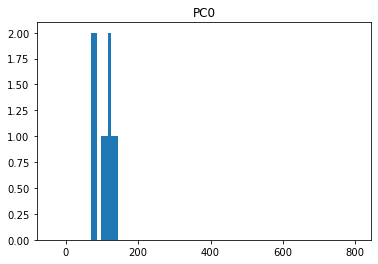

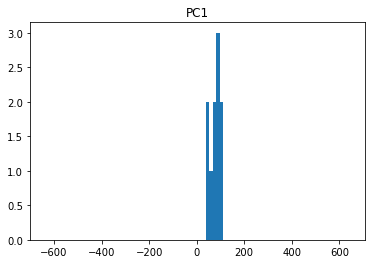

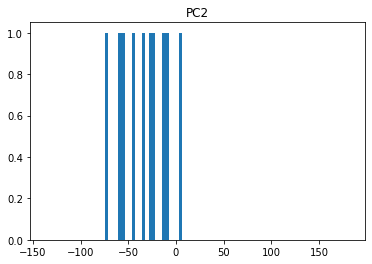

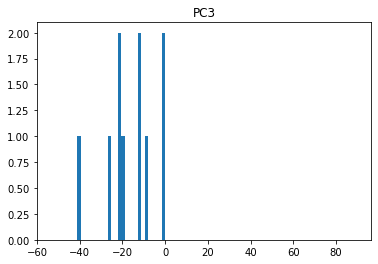

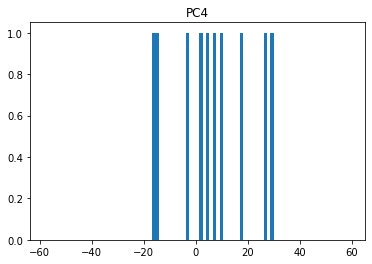

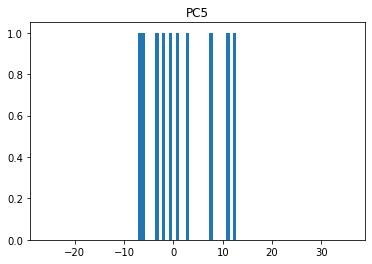

In [24]:
feat_scatter_l = []
for feat in results_df.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(dataset_bank[feat]), np.max(dataset_bank[feat])
    
    ax.hist(results_df[feat], bins=np.linspace(min_feat, max_feat, 100))
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.show()
    
    feat_scatter = np.std(results_df[feat])
    feat_scatter_l.append(feat_scatter)   

In [25]:
print("Scatter mean:", np.mean(feat_scatter_l))
print("Scatter median:", np.median(feat_scatter_l))
print("Scatter std:", np.std(feat_scatter_l))
print("Scatter max:", np.max(feat_scatter_l))
print("Scatter min:", np.min(feat_scatter_l))

Scatter mean: 16.0073059875451
Scatter median: 16.433327804601316
Scatter std: 5.9121501276339625
Scatter max: 23.477274383623797
Scatter min: 6.40230494408193
